### DOWNLOADING AND WORKING WITH DIRECTORIES



In [1]:
!pip install scipy
!pip install catboost
import scipy
import catboost

   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/102.4 MB 2.5 MB/s eta 0:00:41
   ---------------------------------------- 0.8/102.4 MB 2.2 MB/s eta 0:00:47
    --------------------------------------- 1.3/102.4 MB 2.4 MB/s eta 0:00:42
    --------------------------------------- 2.4/102.4 MB 2.9 MB/s eta 0:00:35
   - -------------------------------------- 3.7/102.4 MB 3.6 MB/s eta 0:00:28
   - -------------------------------------- 5.0/102.4 MB 4.1 MB/s eta 0:00:24
   -- ------------------------------------- 6.3/102.4 MB 4.4 MB/s eta 0:00:22
   -- ------------------------------------- 7.6/102.4 MB 4.7 MB/s eta 0:00:21
   --- ------------------------------------ 8.9/102.4 MB 4.9 MB/s eta 0:00:20
   ---- ----------------------------------- 10.5/102.4 MB 5.1 MB/s eta 0:00:18
   ---- ----------------------------------- 11.8/102.4 MB 5.2 MB/s eta 0:00:18
   ----- ---------------------------------- 13.4/102.4 MB 5.4 MB/s et

Note: you may need to restart the kernel to use updated packages.


In [32]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



In [41]:
#load dataset
df=pd.read_csv(r"D:\Projects\Minor\test\final_insect_env_merged.csv")


### EXPLORING DATASET

In [42]:
#top 5 rows --gives a peak into what the data feels like
df.head()

,band_high_ratio,band_low_ratio,band_midhigh_ratio,band_midlow_ratio,crest_factor,delta2_mean_0,delta2_mean_1,delta2_mean_10,delta2_mean_11,delta2_mean_12,...,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,spectral_contrast_mean,spectral_contrast_std,spectral_entropy,zcr_mean,zcr_std,label,file
0,0.257911,0.204298,0.272213,0.265578,9.767627,0.811312,-0.920065,-0.133866,0.206452,-0.320807,...,941.834808,2761.554467,2052.424477,25.566625,18.169741,4.105797,0.145474,0.130065,Others,Acheta_domesticus_IN124525522_489323.mp3_seg1
1,0.226499,0.287861,0.215364,0.270276,5.360852,0.235726,-0.199774,-0.059358,0.059756,0.083968,...,681.027411,4747.901322,428.542283,25.110646,18.056233,3.307361,0.396796,0.056659,Others,Acheta_domesticus_IN127302833_504464.mp3_seg1
2,0.233757,0.279548,0.212779,0.273915,7.194289,0.157504,-0.205828,-0.001150,0.010887,-0.045228,...,867.579425,4713.336356,472.476708,25.204497,19.495164,3.670300,0.409585,0.053979,Others,Acheta_domesticus_IN129524334_514824.mp3_seg1
3,0.340228,0.140754,0.270075,0.248943,8.033413,-0.964081,-0.167056,-0.060476,0.024799,0.205641,...,516.222035,3751.730844,991.229200,24.004236,14.984841,3.818347,0.267383,0.096343,Others,Acheta_domesticus_IN133903352_531667.mp3_seg1
4,0.301414,0.173327,0.287122,0.238137,12.853089,-0.204747,0.084073,0.039222,-0.027307,-0.063621,...,726.438356,1130.152501,1124.930070,22.420409,12.488445,3.526119,0.064667,0.076704,Others,Acheta_domesticus_IN178806290_794319.wav_seg1


In [43]:
#viewing last 5 entries of the dataset
df.tail()

,band_high_ratio,band_low_ratio,band_midhigh_ratio,band_midlow_ratio,crest_factor,delta2_mean_0,delta2_mean_1,delta2_mean_10,delta2_mean_11,delta2_mean_12,...,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,spectral_contrast_mean,spectral_contrast_std,spectral_entropy,zcr_mean,zcr_std,label,file
67580,0.430377,0.094462,0.355377,0.119784,7.755853,-0.000218,-0.082298,-0.002431,-0.011256,0.009190,...,444.075103,2310.865699,347.664224,19.622384,10.379374,5.183470,0.109931,0.024121,Env,5-61635-A-8.wav_seg2
67581,0.424068,0.111221,0.330373,0.134338,9.994474,0.094057,0.065566,0.015924,-0.001011,0.011594,...,447.922949,2419.330196,307.671748,19.855429,10.293117,5.307016,0.115257,0.026427,Env,5-61635-A-8.wav_seg3
67582,0.425274,0.109627,0.332374,0.132726,10.056218,-0.169405,-0.039581,-0.023954,0.030058,0.008756,...,424.902027,2394.750849,292.013364,19.869623,10.355157,5.273860,0.113255,0.026402,Env,5-61635-A-8.wav_seg4
67583,0.456861,0.093982,0.345512,0.103645,8.495244,-0.065852,0.040039,0.022590,-0.024449,0.005639,...,412.346014,2339.180935,301.844956,19.886001,10.261412,5.301218,0.117161,0.023556,Env,5-61635-A-8.wav_seg5
67584,0.296998,0.260493,0.235326,0.207183,11.341613,-0.702258,0.342347,-0.068655,-0.004567,0.069628,...,1003.806265,2972.368260,1231.278767,19.532317,10.867011,5.322042,0.184698,0.094386,Env,5-9032-A-0.wav_seg1


In [44]:
#some std parameters of the dataset
df.describe()

,band_high_ratio,band_low_ratio,band_midhigh_ratio,band_midlow_ratio,crest_factor,delta2_mean_0,delta2_mean_1,delta2_mean_10,delta2_mean_11,delta2_mean_12,...,snr,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,spectral_contrast_mean,spectral_contrast_std,spectral_entropy,zcr_mean,zcr_std
count,67585.000000,67585.000000,67585.000000,67585.000000,67585.000000,67585.000000,67585.000000,67585.000000,67585.000000,67585.000000,...,67585.000000,67585.000000,67585.000000,67585.000000,67585.000000,67585.000000,67585.000000,67585.000000,67585.000000,67585.000000
mean,0.341694,0.160739,0.264933,0.232634,11.779479,-0.134526,0.028733,0.008385,-0.006761,0.008660,...,0.263819,2313.783133,484.340426,3960.547392,1117.384695,23.490150,14.916326,4.602969,0.303903,0.109738
std,3.176868,3.036448,0.950727,1.117496,9.943566,0.502925,0.280548,0.081231,0.077369,0.072297,...,0.037003,633.457785,266.085815,1738.791861,753.705867,2.800254,2.376057,1.215185,0.176735,0.067421
min,-361.983887,-405.600281,-169.361939,-209.122528,1.596500,-4.286964,-1.587244,-0.507837,-0.595795,-0.379404,...,-4.873278,91.451252,25.608443,66.468013,38.003064,4.429678,2.065284,0.614768,0.000000,0.000000
25%,0.230642,0.120630,0.217392,0.203169,7.014344,-0.389036,-0.117269,-0.040409,-0.052769,-0.035508,...,0.264446,1881.934683,276.828292,2644.447873,523.994507,21.678935,13.413672,3.672195,0.162598,0.057364
50%,0.299180,0.196170,0.266243,0.248930,8.934973,-0.212827,0.002198,0.008058,-0.006268,0.008015,...,0.264555,2319.168610,436.506280,3769.687617,938.530507,23.318310,14.804070,4.831988,0.277990,0.096652
75%,0.386912,0.254533,0.311764,0.287910,12.634285,0.020955,0.141460,0.057179,0.039956,0.052210,...,0.264567,2754.285072,649.723218,5063.681717,1558.568282,25.103162,16.348689,5.608466,0.416004,0.149948
max,510.811981,510.147614,104.910904,78.720284,198.448761,3.632749,2.837610,0.538913,0.511386,0.441896,...,0.386226,4288.991278,2096.723603,9957.865049,4960.981279,38.164479,26.686327,6.871365,0.914889,0.453156


In [45]:
#names of columns of dataset
df.columns

Index(['band_high_ratio', 'band_low_ratio', 'band_midhigh_ratio',
       'band_midlow_ratio', 'crest_factor', 'delta2_mean_0', 'delta2_mean_1',
       'delta2_mean_10', 'delta2_mean_11', 'delta2_mean_12',
       ...
       'spectral_bandwidth_std', 'spectral_centroid_mean',
       'spectral_centroid_std', 'spectral_contrast_mean',
       'spectral_contrast_std', 'spectral_entropy', 'zcr_mean', 'zcr_std',
       'label', 'file'],
      dtype='object', length=268)

## DATA PREPROCESSING

### CHECKING FOR COLUMNS WITH STRING DATATYPE

In [48]:
for col in df.columns:
  if(df[col].dtype=='object'):
    print(col)

label


### REMOVING COLUMNS THAT DO NOT HAVE AN IMPACT

In [49]:
# removing 'file' column as it doesn't impact the prediction
df=df.drop(['file'], axis=1)

KeyError: "['file'] not found in axis"

###CHECKING FOR MISSING VALUES

In [50]:
#checking for missing values
cols_with_missing=[col for col in df.columns if df[col].isnull().any()]
print(cols_with_missing)

['Unnamed: 165']


In [51]:
df = df.drop(columns=['Unnamed: 165'], errors='ignore')
df = df.replace([np.inf, -np.inf], np.nan)
numeric_cols = df.select_dtypes(include=np.number).columns
df = df.dropna(subset=numeric_cols).reset_index(drop=True)
zero_var_cols = [c for c in numeric_cols if df[c].std() == 0]
df = df.drop(columns=zero_var_cols)
print("Dropped zero-variance columns:", zero_var_cols)
df[numeric_cols] = df[numeric_cols].clip(lower=df[numeric_cols].quantile(0.001),
                                         upper=df[numeric_cols].quantile(0.999),
                                         axis=1)


Dropped zero-variance columns: []


In [52]:
#checking count of columns with missing values as well
df.isnull().sum().sum()

np.int64(0)

### CHECK FOR DUPLICATE VALUES

In [53]:
#checking for duplicate values
df.duplicated().sum()

np.int64(7)

In [55]:
#removing duplicated data
df=df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

np.int64(0)

### CHECKING FOR OUTLIERS

In [56]:

# InterQuartile Range Check
numeric_cols=df.select_dtypes(include=np.number).columns # taking only numeric columns

outliers={}

for col in numeric_cols:
  Q1=df[col].quantile(0.25)
  Q2=df[col].quantile(0.75)
  IQR=Q2-Q1
  lower=Q1-1.5*IQR
  upper=Q2+1.5*IQR
  outliers[col]=df[(df[col]<lower)|(df[col]>upper)][col].count()

#show outliers
{k:v for k,v in outliers.items() if v>0}

{'band_high_ratio': np.int64(3614),
 'band_low_ratio': np.int64(3903),
 'band_midhigh_ratio': np.int64(5223),
 'band_midlow_ratio': np.int64(4645),
 'crest_factor': np.int64(5769),
 'delta2_mean_0': np.int64(5545),
 'delta2_mean_1': np.int64(4846),
 'delta2_mean_10': np.int64(1640),
 'delta2_mean_11': np.int64(1673),
 'delta2_mean_12': np.int64(1575),
 'delta2_mean_13': np.int64(1369),
 'delta2_mean_14': np.int64(1339),
 'delta2_mean_15': np.int64(1400),
 'delta2_mean_16': np.int64(1313),
 'delta2_mean_17': np.int64(1491),
 'delta2_mean_18': np.int64(1527),
 'delta2_mean_19': np.int64(1516),
 'delta2_mean_2': np.int64(3135),
 'delta2_mean_20': np.int64(1422),
 'delta2_mean_21': np.int64(1333),
 'delta2_mean_22': np.int64(1241),
 'delta2_mean_23': np.int64(1216),
 'delta2_mean_24': np.int64(1106),
 'delta2_mean_25': np.int64(1210),
 'delta2_mean_26': np.int64(1250),
 'delta2_mean_27': np.int64(1184),
 'delta2_mean_28': np.int64(1228),
 'delta2_mean_29': np.int64(1217),
 'delta2_mean_3':

In [57]:
# Z-score outlier detection
from scipy import stats
z_scores=np.abs(stats.zscore(df[numeric_cols]))
outlier_rows=np.where(z_scores>3)[0]
len(outlier_rows)


175640

### CHECKING CLASS DISTRIBUTION


In [58]:
# Checking counts in individual categories
counts=df['label'].value_counts()
counts



label
Others                    57668
Env                        7941
Chorthippus_biguttulus     1016
Gryllus_bimaculatus         587
Ruspolia_nitidula           366
Name: count, dtype: int64

In [59]:
df['label'].value_counts(dropna=False)
df[df['label'].isna()].head()


,band_high_ratio,band_low_ratio,band_midhigh_ratio,band_midlow_ratio,crest_factor,delta2_mean_0,delta2_mean_1,delta2_mean_10,delta2_mean_11,delta2_mean_12,...,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,spectral_contrast_mean,spectral_contrast_std,spectral_entropy,zcr_mean,zcr_std,label


D:\Projects\pip_temp\ipykernel_11760\2562783928.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts, x='label', y='count', palette='viridis')


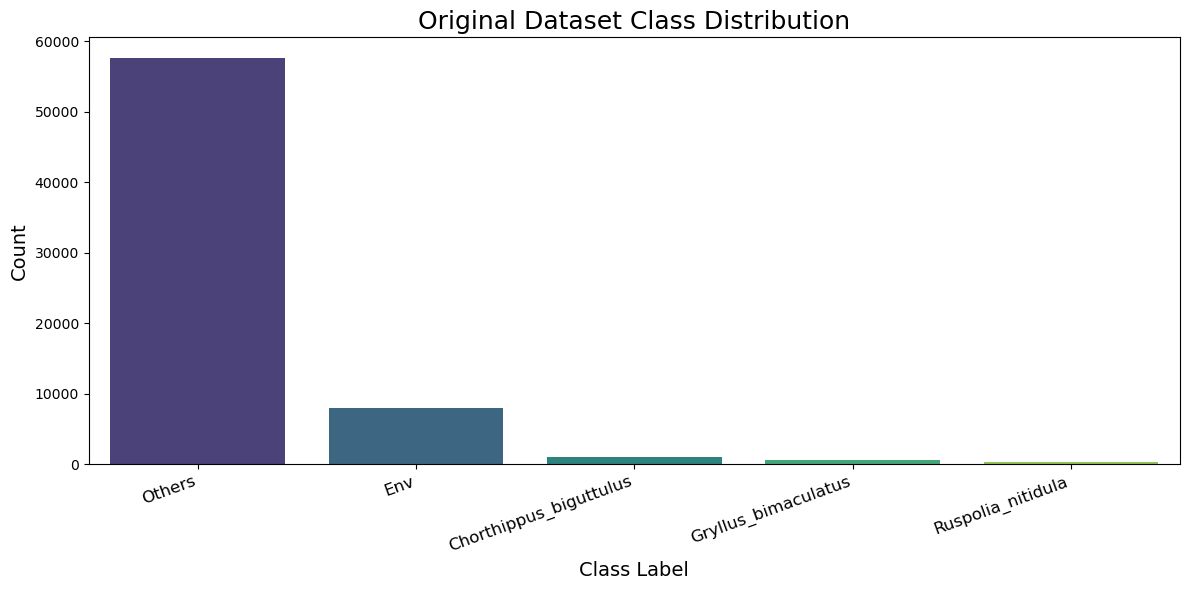

In [60]:
# visualising the distributions
counts = df['label'].value_counts().reset_index()
counts.columns = ['label', 'count']

plt.figure(figsize=(12,6))
sns.barplot(data=counts, x='label', y='count', palette='viridis')

plt.title("Original Dataset Class Distribution", fontsize=18)
plt.xlabel("Class Label", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=20, ha='right', fontsize=12)

plt.tight_layout()
plt.show()


## DATA BALANCING

In [61]:
# Seperating classes acc. to label
others_df=df[df['label']=="Others"].copy()
env_df=df[df['label']=="Env"].copy()
species_df=df[~df['label'].isin(["Others", "Env"])].copy()

### CLUSTERING BASED SAMPLING FOR 'OTHERS'

In [62]:
#keeping all numeric columns
feat_cols=[c for c in df.columns if c not in['label']]

In [63]:
# scaling numeric values for uniformity
scaler=StandardScaler()
scaler.fit(df[feat_cols])
X_others = scaler.transform(others_df[feat_cols])
X_env    = scaler.transform(env_df[feat_cols])


In [64]:
# Applying KMeans
RANDOM_STATE=42
n_clusters_others = 35
n_clusters_env    = 25
kmeans_others = MiniBatchKMeans(
    n_clusters=n_clusters_others,
    batch_size=1024,
    random_state=RANDOM_STATE
)

kmeans_env = MiniBatchKMeans(
    n_clusters=n_clusters_env,
    batch_size=1024,
    random_state=RANDOM_STATE
)
others_clusters = kmeans_others.fit_predict(X_others)
env_clusters    = kmeans_env.fit_predict(X_env)

# Assign cluster IDs (aligned indices)
others_df['cluster'] = others_clusters
env_df['cluster']    = env_clusters

D:\Apps\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
D:\Apps\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [65]:
# Sampling individual categories
def proportional_sample(df_sub, cluster_col, target_n, random_state=42):
    clusters = df_sub[cluster_col].unique()
    samples = []
    total = len(df_sub)

    for cl in clusters:
        cluster_df = df_sub[df_sub[cluster_col] == cl]
        size = len(cluster_df)

        # proportional allocation
        n = max(1, int(round(size / total * target_n)))
        # safe sampling
        selected = cluster_df.sample(
            n=min(n, size),
            replace=False,
            random_state=random_state
        )
        samples.append(selected)

    sampled = pd.concat(samples).reset_index(drop=True)

    # Adjust overshoot/undershoot
    if len(sampled) > target_n:
        sampled = sampled.sample(target_n, random_state=random_state).reset_index(drop=True)
    elif len(sampled) < target_n:
        needed = target_n - len(sampled)
        remaining = df_sub.loc[~df_sub.index.isin(sampled.index)]
        extra = remaining.sample(needed, random_state=random_state)
        sampled = pd.concat([sampled, extra]).reset_index(drop=True)
    return sampled
target_others = 3000
target_env    = 2500

others_sample = proportional_sample(others_df, 'cluster', target_others)
env_sample    = proportional_sample(env_df, 'cluster', target_env)
# Remove temporary clustering column
others_sample = others_sample.drop(columns=['cluster'], errors='ignore')
env_sample    = env_sample.drop(columns=['cluster'], errors='ignore')





In [66]:
# creating the balanced dataset that'll be used further
balanced_df = pd.concat(
    [species_df, others_sample, env_sample],
    ignore_index=True
)
balanced_df = balanced_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

### CLUSTERING BASED SAMPLING FOR 'ENV'

In [67]:
# combining everything
len(balanced_df)

7469

### CHECKING IF ALL WORK DONE CORRECTLY

In [68]:
len(balanced_df)
balanced_df.isnull().sum().sum()



np.int64(0)

In [69]:
balanced_df['label'].value_counts()

label
Others                    3000
Env                       2500
Chorthippus_biguttulus    1016
Gryllus_bimaculatus        587
Ruspolia_nitidula          366
Name: count, dtype: int64

D:\Projects\pip_temp\ipykernel_11760\2192599947.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_df, x='label', palette='viridis')


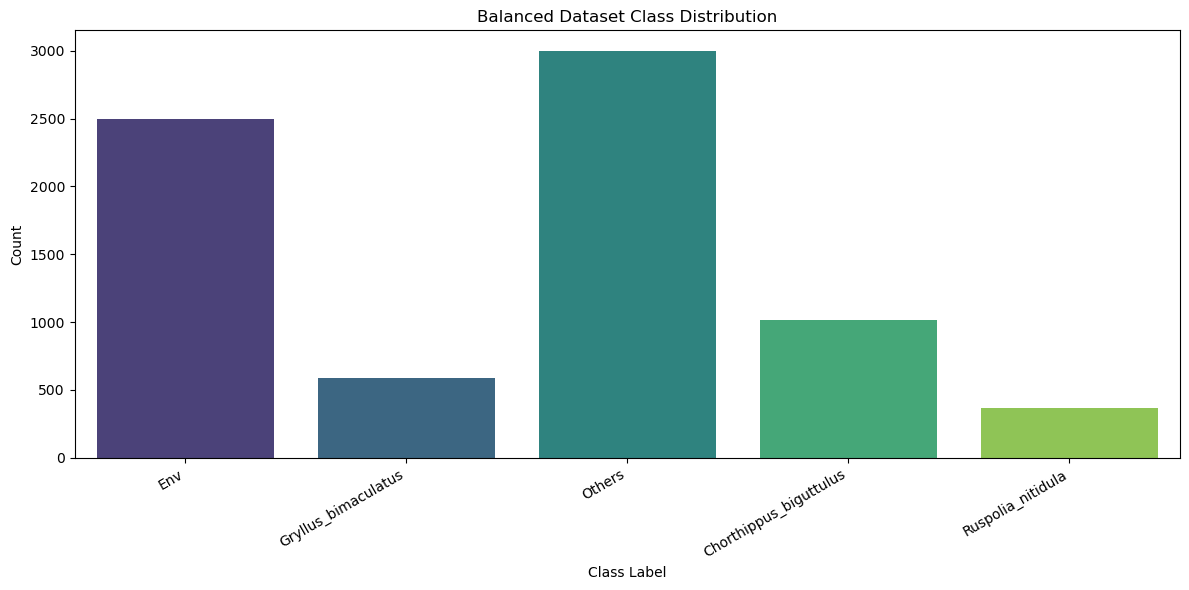

In [70]:
plt.figure(figsize=(12,6))
sns.countplot(data=balanced_df, x='label', palette='viridis')
plt.title("Balanced Dataset Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.xticks(rotation=30, ha='right')   # rotate & align right
plt.tight_layout()
plt.show()


## DATA SCALING AND ENCODING

In [71]:
# keeping only numeric data
X=balanced_df.drop(['label'], axis=1)

# Target column
y=balanced_df['label']

# Splitting data for training and testing
X_train, X_test, y_train, y_test=train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [72]:
# Scaling data using Robust Scaler
scaler=RobustScaler()

# fit only on training data
X_train_scaled=scaler.fit_transform(X_train)

#transform test data using same scaling
X_test_scaled=scaler.transform(X_test)




===== SUMMARY STATISTICS (SCALED DATA) =====


,count,mean,std,min,25%,50%,75%,max
band_high_ratio,5975.0,0.350146,2.233534,-9.939915,-0.395248,0.0,0.604752,24.702193
band_low_ratio,5975.0,-0.325942,2.163126,-24.973578,-0.574090,0.0,0.425910,11.034758
band_midhigh_ratio,5975.0,0.087116,1.477319,-8.310131,-0.430538,0.0,0.569462,13.626888
band_midlow_ratio,5975.0,-0.269490,1.777736,-18.387220,-0.598227,0.0,0.401773,7.185341
crest_factor,5975.0,0.476680,1.668695,-1.055362,-0.337854,0.0,0.662146,16.190397
...,...,...,...,...,...,...,...,...
spectral_contrast_mean,5975.0,0.041800,0.740226,-2.375181,-0.497024,0.0,0.502976,3.001650
spectral_contrast_std,5975.0,0.018085,0.675961,-2.282374,-0.534345,0.0,0.465655,2.520063
spectral_entropy,5975.0,-0.072484,0.613124,-1.824567,-0.546969,0.0,0.453031,1.020864
zcr_mean,5975.0,0.136912,0.742717,-0.927703,-0.448960,0.0,0.551040,2.706107



===== NaN / Inf Check =====
NaN count: 0
Inf count: 0


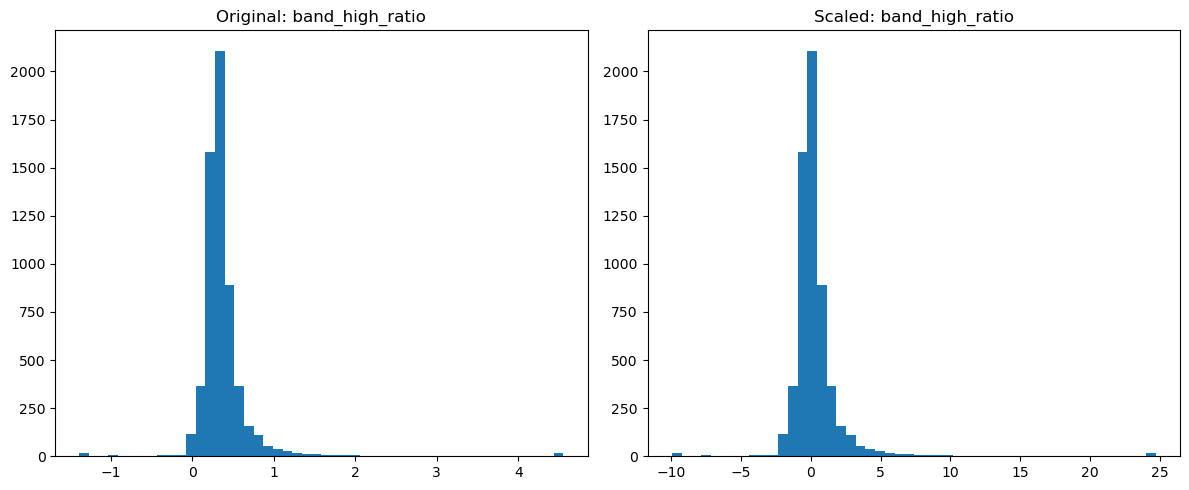

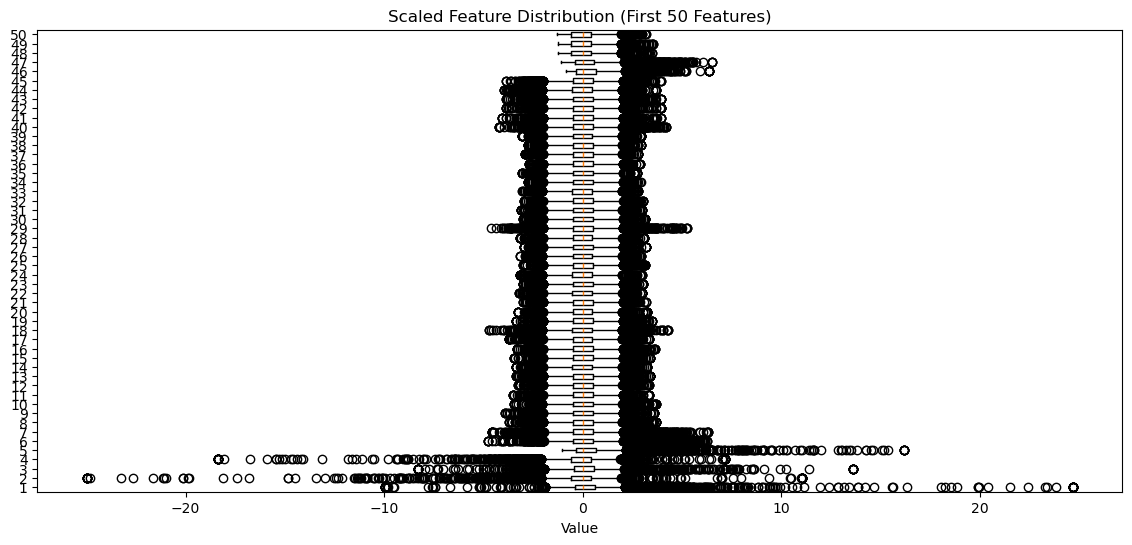


===== RobustScaler Center (Median of Each Feature) =====


band_high_ratio            0.319704
band_low_ratio             0.175347
band_midhigh_ratio         0.276429
band_midlow_ratio          0.233962
crest_factor               8.609844
                            ...    
spectral_contrast_mean    22.402638
spectral_contrast_std     13.955588
spectral_entropy           4.683614
zcr_mean                   0.226998
zcr_std                    0.080437
Length: 265, dtype: float64


===== RobustScaler Scale (IQR of Each Feature) =====


band_high_ratio           0.171314
band_low_ratio            0.152292
band_midhigh_ratio        0.087113
band_midlow_ratio         0.091933
crest_factor              6.046581
                            ...   
spectral_contrast_mean    3.968787
spectral_contrast_std     3.683130
spectral_entropy          2.030807
zcr_mean                  0.236056
zcr_std                   0.096368
Length: 265, dtype: float64

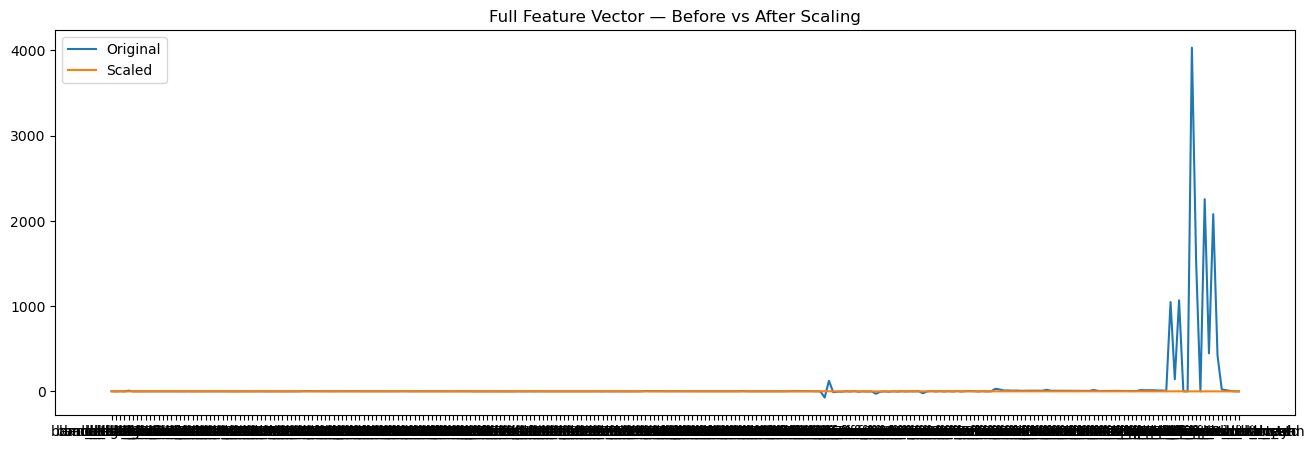

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1. Create a DataFrame for scaled features
# -----------------------------
scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

print("\n===== SUMMARY STATISTICS (SCALED DATA) =====")
display(scaled_df.describe().T)


# -----------------------------
# 2. Check for NaN / Inf values
# -----------------------------
print("\n===== NaN / Inf Check =====")
print("NaN count:", scaled_df.isna().sum().sum())
print("Inf count:", np.isinf(scaled_df).sum().sum())


# -----------------------------
# 3. Compare ONE FEATURE before & after scaling
# -----------------------------
feature = X_train.columns[0]  # choose first feature

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(X_train[feature], bins=50)
plt.title(f"Original: {feature}")

plt.subplot(1,2,2)
plt.hist(scaled_df[feature], bins=50)
plt.title(f"Scaled: {feature}")

plt.tight_layout()
plt.show()


# -----------------------------
# 4. Boxplot of first 50 scaled features
# -----------------------------
plt.figure(figsize=(14,6))
plt.boxplot(scaled_df.iloc[:, :50], vert=False)
plt.title("Scaled Feature Distribution (First 50 Features)")
plt.xlabel("Value")
plt.show()


# -----------------------------
# 5. Inspect RobustScaler params
# -----------------------------
print("\n===== RobustScaler Center (Median of Each Feature) =====")
center_series = pd.Series(scaler.center_, index=X_train.columns)
display(center_series)

print("\n===== RobustScaler Scale (IQR of Each Feature) =====")
scale_series = pd.Series(scaler.scale_, index=X_train.columns)
display(scale_series)


# -----------------------------
# 6. Compare full feature vector for one sample
# -----------------------------
idx = 0  # choose first sample

plt.figure(figsize=(16,5))
plt.plot(X_train.iloc[idx], label="Original")
plt.plot(scaled_df.iloc[idx], label="Scaled")
plt.legend()
plt.title("Full Feature Vector — Before vs After Scaling")
plt.show()


In [75]:
import pandas as pd
import re

# Convert center_ array to Series
center_series = pd.Series(scaler.center_, index=X_train.columns)

# Filter MFCC mean + std
mfcc_centers = center_series[center_series.index.str.contains(r"mfcc_", regex=True)]

# Filter delta means + std
delta_centers = center_series[center_series.index.str.contains(r"delta_mean_|delta_std_", regex=True)]

# Filter delta2 means + std
delta2_centers = center_series[center_series.index.str.contains(r"delta2_mean_|delta2_std_", regex=True)]

print("==== MFCC CENTERS (mean + std) ====")
display(mfcc_centers)

print("\n==== DELTA CENTERS (mean + std) ====")
display(delta_centers)

print("\n==== DELTA2 CENTERS (mean + std) ====")
display(delta2_centers)


==== MFCC CENTERS (mean + std) ====


mfcc_mean_0    -236.467483
mfcc_mean_1      56.408596
mfcc_mean_10     -2.586477
mfcc_mean_11      5.758588
mfcc_mean_12     -3.424640
                   ...    
mfcc_std_5       15.346922
mfcc_std_6       14.028652
mfcc_std_7       13.438476
mfcc_std_8       12.720120
mfcc_std_9       11.791481
Length: 80, dtype: float64


==== DELTA CENTERS (mean + std) ====


delta_mean_0    -0.227802
delta_mean_1    -0.015408
delta_mean_10    0.002438
delta_mean_11   -0.000686
delta_mean_12    0.002657
                   ...   
delta_std_5      2.755924
delta_std_6      2.557963
delta_std_7      2.432550
delta_std_8      2.329237
delta_std_9      2.181103
Length: 80, dtype: float64


==== DELTA2 CENTERS (mean + std) ====


delta2_mean_0    -0.165710
delta2_mean_1    -0.007176
delta2_mean_10    0.007521
delta2_mean_11   -0.006711
delta2_mean_12    0.007554
                    ...   
delta2_std_5      1.738143
delta2_std_6      1.637953
delta2_std_7      1.568822
delta2_std_8      1.489412
delta2_std_9      1.421035
Length: 80, dtype: float64

KeyError: 'label'

In [78]:
# converting scaled np arrays back to dataframes
X_train_scaled=pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled=pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [79]:
# encoding data for as and when needed
le=LabelEncoder()
y_train_enc=le.fit_transform(y_train)
y_test_enc=le.transform(y_test)

In [80]:
joblib.dump(scaler, "robust_scaler.pkl")
# joblib.dump(scaler, "/content/drive/MyDrive/Insectra/robust_scaler.pkl")

['robust_scaler.pkl']

In [95]:
import json

# Save training column order
with open("feature_order.json", "w") as f:
    json.dump(list(X_train.columns), f)


## MODEL TRAINING AND TESTING

In [81]:
#defining and declaring all the models we'll be trying
models={
    "SVM-RBF": SVC(kernel="rbf", probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=300),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.8),
    # "LightGBM": LGBMClassifier(n_estimators=300, learning_rate=0.05),
    "LogisticRegression": LogisticRegression(max_iter=500),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "CatBoost": CatBoostClassifier(iterations=300, learning_rate=0.05, depth=8, verbose=False, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=400, random_state=42, n_jobs=-1),
    "HistGradientBoosting": HistGradientBoostingClassifier(learning_rate=0.05, max_depth=8, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=300, learning_rate=0.05, random_state=42)

}


----------------------
Training SVM-RBF...
SVM-RBF Accuracy: 0.8353
                        precision    recall  f1-score   support

Chorthippus_biguttulus       0.85      0.51      0.64       203
                   Env       0.98      0.98      0.98       500
   Gryllus_bimaculatus       0.85      0.60      0.70       118
                Others       0.74      0.94      0.83       600
     Ruspolia_nitidula       0.94      0.22      0.36        73

              accuracy                           0.84      1494
             macro avg       0.87      0.65      0.70      1494
          weighted avg       0.85      0.84      0.82      1494



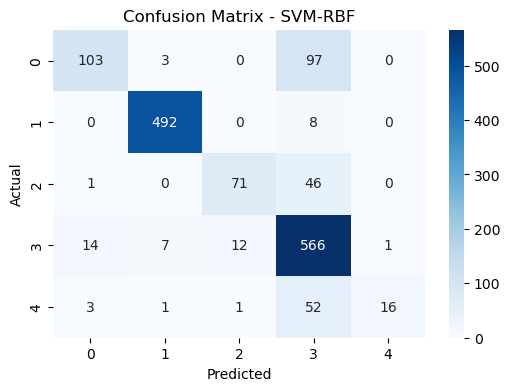


----------------------
Training RandomForest...
RandomForest Accuracy: 0.8574
                        precision    recall  f1-score   support

Chorthippus_biguttulus       0.88      0.52      0.65       203
                   Env       0.99      0.99      0.99       500
   Gryllus_bimaculatus       0.91      0.62      0.74       118
                Others       0.76      0.96      0.85       600
     Ruspolia_nitidula       0.93      0.38      0.54        73

              accuracy                           0.86      1494
             macro avg       0.90      0.70      0.75      1494
          weighted avg       0.87      0.86      0.85      1494



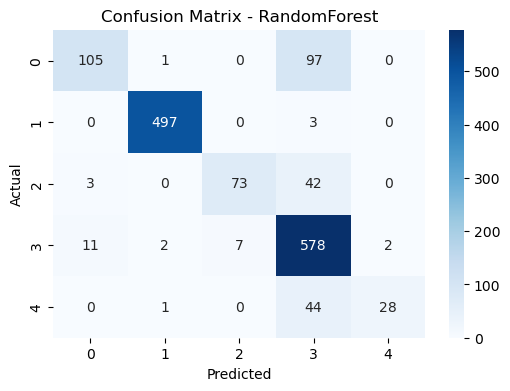


----------------------
Training XGBoost...
XGBoost Accuracy: 0.9029
                        precision    recall  f1-score   support

Chorthippus_biguttulus       0.87      0.75      0.81       203
                   Env       1.00      1.00      1.00       500
   Gryllus_bimaculatus       0.93      0.76      0.84       118
                Others       0.84      0.95      0.89       600
     Ruspolia_nitidula       0.93      0.55      0.69        73

              accuracy                           0.90      1494
             macro avg       0.91      0.80      0.84      1494
          weighted avg       0.91      0.90      0.90      1494



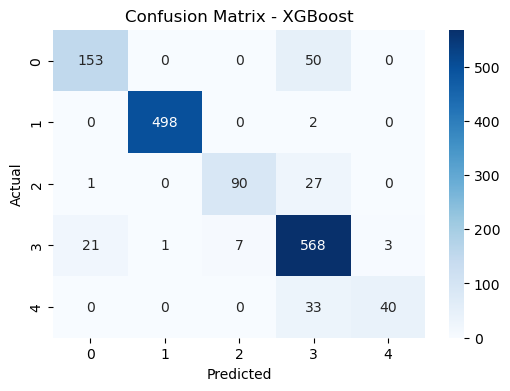


----------------------
Training LogisticRegression...
LogisticRegression Accuracy: 0.8320
                        precision    recall  f1-score   support

Chorthippus_biguttulus       0.69      0.65      0.67       203
                   Env       1.00      0.99      0.99       500
   Gryllus_bimaculatus       0.79      0.66      0.72       118
                Others       0.78      0.85      0.81       600
     Ruspolia_nitidula       0.53      0.41      0.46        73

              accuracy                           0.83      1494
             macro avg       0.76      0.71      0.73      1494
          weighted avg       0.83      0.83      0.83      1494



D:\Apps\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


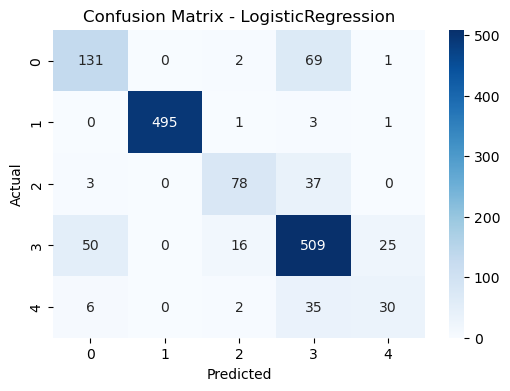


----------------------
Training KNN...
KNN Accuracy: 0.7845
                        precision    recall  f1-score   support

Chorthippus_biguttulus       0.48      0.77      0.59       203
                   Env       0.97      0.97      0.97       500
   Gryllus_bimaculatus       0.87      0.68      0.76       118
                Others       0.79      0.71      0.75       600
     Ruspolia_nitidula       0.79      0.30      0.44        73

              accuracy                           0.78      1494
             macro avg       0.78      0.69      0.70      1494
          weighted avg       0.81      0.78      0.79      1494



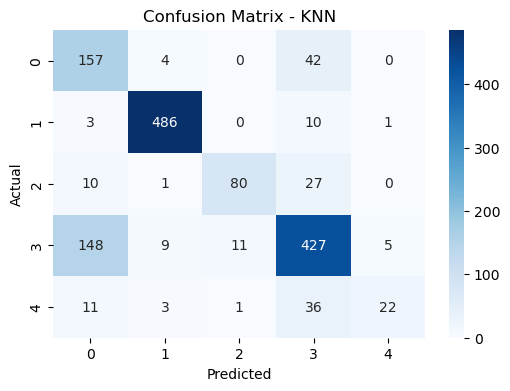


----------------------
Training CatBoost...
CatBoost Accuracy: 0.8782
                        precision    recall  f1-score   support

Chorthippus_biguttulus       0.89      0.68      0.77       203
                   Env       1.00      1.00      1.00       500
   Gryllus_bimaculatus       0.89      0.69      0.78       118
                Others       0.79      0.94      0.86       600
     Ruspolia_nitidula       0.83      0.40      0.54        73

              accuracy                           0.88      1494
             macro avg       0.88      0.74      0.79      1494
          weighted avg       0.88      0.88      0.87      1494



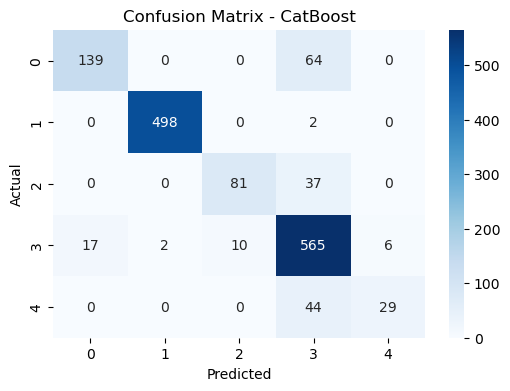


----------------------
Training ExtraTrees...
ExtraTrees Accuracy: 0.8561
                        precision    recall  f1-score   support

Chorthippus_biguttulus       0.90      0.48      0.63       203
                   Env       0.98      0.99      0.99       500
   Gryllus_bimaculatus       0.94      0.63      0.75       118
                Others       0.75      0.97      0.85       600
     Ruspolia_nitidula       1.00      0.41      0.58        73

              accuracy                           0.86      1494
             macro avg       0.91      0.70      0.76      1494
          weighted avg       0.88      0.86      0.84      1494



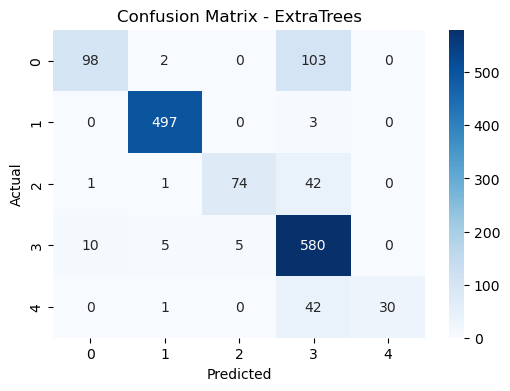


----------------------
Training HistGradientBoosting...
HistGradientBoosting Accuracy: 0.9003
                        precision    recall  f1-score   support

Chorthippus_biguttulus       0.87      0.74      0.80       203
                   Env       0.99      1.00      1.00       500
   Gryllus_bimaculatus       0.92      0.75      0.82       118
                Others       0.83      0.94      0.88       600
     Ruspolia_nitidula       0.93      0.59      0.72        73

              accuracy                           0.90      1494
             macro avg       0.91      0.80      0.85      1494
          weighted avg       0.90      0.90      0.90      1494



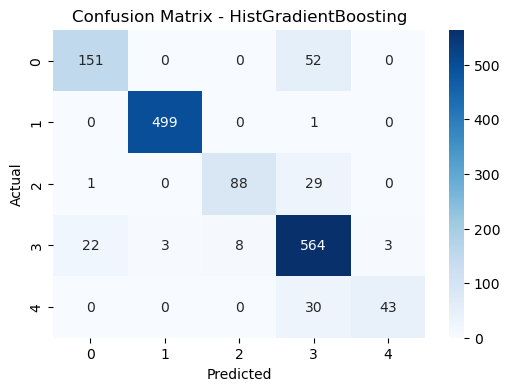


----------------------
Training AdaBoost...
AdaBoost Accuracy: 0.7195
                        precision    recall  f1-score   support

Chorthippus_biguttulus       1.00      0.00      0.01       203
                   Env       0.92      1.00      0.96       500
   Gryllus_bimaculatus       0.00      0.00      0.00       118
                Others       0.60      0.95      0.74       600
     Ruspolia_nitidula       0.80      0.05      0.10        73

              accuracy                           0.72      1494
             macro avg       0.66      0.40      0.36      1494
          weighted avg       0.72      0.72      0.62      1494



D:\Apps\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Apps\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Apps\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Apps\Anaconda\Lib\site-packages\sklearn\metrics\_classificati

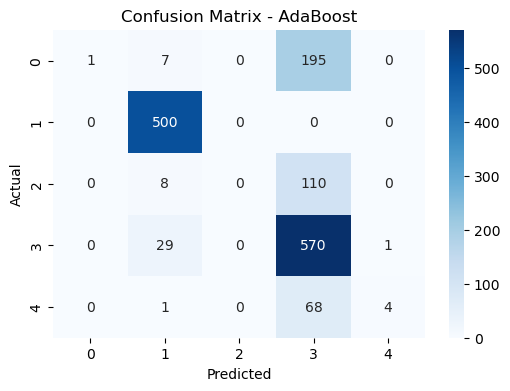

In [83]:
results = {}
# storing to store individual f1 scores for each category and using each model
f1_results = []


for name, model in models.items():
    print(f"\n----------------------")
    print(f"Training {name}...")

    if(name in ['XGBoost', 'LightGBM', 'HistGradientBoosting', 'AdaBoost']):
      model.fit(X_train_scaled.values, y_train_enc)
      preds = model.predict(X_test_scaled.values)
      preds = le.inverse_transform(preds)  # convert back to strings
    else:
      model.fit(X_train_scaled, y_train)
      preds = model.predict(X_test_scaled)
      # acc = accuracy_score(y_test, preds)

    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))
    # store per-class F1 scores
    report = classification_report(y_test, preds, output_dict=True)
    f1_row = {cls: report[cls]["f1-score"]
              for cls in report.keys()
              if cls not in ["accuracy", "macro avg", "weighted avg"]}
    f1_row["model"] = name
    f1_results.append(f1_row)


    # Save results
    results[name] = acc

    # Confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## DEEP LEARNING MODELS

In [90]:
!pip install --upgrade pip
!pip install tensorflow==2.12.0
!pip install tensorflow-directml-plugin -f https://aka.ms/tensorflow-directml-plugin


  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
D:\Apps\Anaconda\python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0


Looking in links: https://aka.ms/tensorflow-directml-plugin


ERROR: Could not find a version that satisfies the requirement tensorflow-directml-plugin (from versions: none)
ERROR: No matching distribution found for tensorflow-directml-plugin


D:\Apps\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 261, 64)             │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 261, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 130, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 126, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 126, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 63, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 61, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 61, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7680)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,966,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,141,701 (8.17 MB)

 Trainable params: 2,140,805 (8.17 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/60
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6731 - loss: 1.0968 - val_accuracy: 0.4091 - val_loss: 4.0403 - learning_rate: 0.0010
Epoch 2/60
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7722 - loss: 0.6323 - val_accuracy: 0.7960 - val_loss: 0.5399 - learning_rate: 0.0010
Epoch 3/60
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8001 - loss: 0.5402 - val_accuracy: 0.8172 - val_loss: 0.4676 - learning_rate: 0.0010
Epoch 4/60
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8295 - loss: 0.4440 - val_accuracy: 0.8462 - val_loss: 0.3990 - learning_rate: 0.0010
Epoch 5/60
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8537 - loss: 0.3886 - val_accuracy: 0.8495 - val_loss: 0.3704 - learning_rate: 0.0010
Epoch 6/60
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8889 - loss: 0.3043 - val_accuracy: 0.8484 - val_loss: 0.3889 - learning_rate: 0.0010
Epoch 7/60
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9041 - loss: 0.

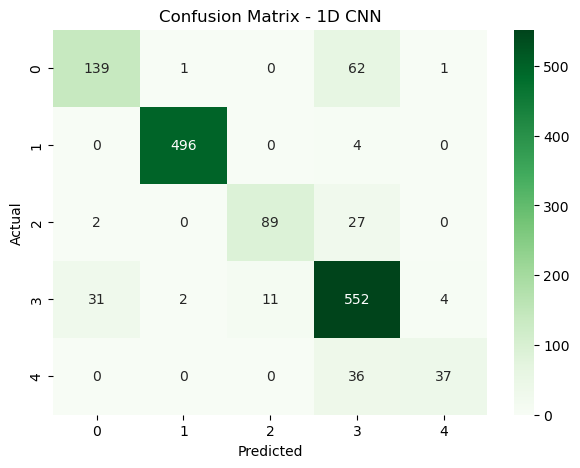

In [91]:
# CNN reshape
X_train_np = X_train_scaled.to_numpy()
X_test_np  = X_test_scaled.to_numpy()

X_train_cnn = X_train_np.reshape(X_train_np.shape[0], X_train_np.shape[1], 1)
X_test_cnn  = X_test_np.reshape(X_test_np.shape[0], X_test_np.shape[1], 1)

# One-hot
y_enc = le.fit_transform(y)
num_classes = len(np.unique(y_enc))
y_train_cat = tf.keras.utils.to_categorical(y_train_enc, num_classes)
y_test_cat  = tf.keras.utils.to_categorical(y_test_enc, num_classes)

# Building the 1D CNN
def build_1d_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Conv1D(128, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Conv1D(256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (X_train_cnn.shape[1], 1)
cnn = build_1d_cnn(input_shape, num_classes)
cnn.summary()

es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Training
history = cnn.fit(
    X_train_cnn, y_train_cat,
    epochs=60,
    batch_size=32,
    validation_split=0.15,
    callbacks=[es, rlr],
    verbose=1
)

#Testing
test_loss, test_acc = cnn.evaluate(X_test_cnn, y_test_cat, verbose=0)

# Predictions
preds_proba = cnn.predict(X_test_cnn)
preds = np.argmax(preds_proba, axis=1)
predicted_labels = le.inverse_transform(preds)
true_labels = le.inverse_transform(y_test_enc)

# Classification report
print("\nClassification Report:")
#cnn_report=(classification_report(true_labels, predicted_labels))
cnn_report = classification_report(true_labels, predicted_labels, output_dict=True)
print(cnn_report)
f1_row = {cls: cnn_report[cls]["f1-score"]
          for cls in cnn_report.keys()
          if cls not in ["accuracy", "macro avg", "weighted avg"]}
f1_row["model"] = "1D CNN"
f1_results.append(f1_row)

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, cmap="Greens", fmt="d")
plt.title("Confusion Matrix - 1D CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [92]:
final_f1_table = pd.DataFrame(f1_results).set_index("model")
display(final_f1_table)


,Chorthippus_biguttulus,Env,Gryllus_bimaculatus,Others,Ruspolia_nitidula
model,,,,,
SVM-RBF,0.635802,0.981057,0.702970,0.826881,0.355556
RandomForest,0.652174,0.993007,0.737374,0.847507,0.543689
XGBoost,0.809524,0.996997,0.837209,0.887500,0.689655
LogisticRegression,0.666667,0.994975,0.718894,0.812450,0.461538
KNN,0.590226,0.969093,0.761905,0.747811,0.435644
CatBoost,0.774373,0.996000,0.775120,0.861280,0.537037
ExtraTrees,0.628205,0.988072,0.751269,0.846715,0.582524
HistGradientBoosting,0.801061,0.996008,0.822430,0.884013,0.722689
AdaBoost,0.009804,0.956938,0.000000,0.738820,0.102564


## FINAL MODEL SAVING


In [93]:
# saving encoder for xgboost
joblib.dump(le, "label_encoder.pkl")
# choosing xgboost as the final model as giving best results
joblib.dump(models["XGBoost"], "xgboost_model.pkl")


['xgboost_model.pkl']

In [94]:
print(list(X.columns))


['band_high_ratio', 'band_low_ratio', 'band_midhigh_ratio', 'band_midlow_ratio', 'crest_factor', 'delta2_mean_0', 'delta2_mean_1', 'delta2_mean_10', 'delta2_mean_11', 'delta2_mean_12', 'delta2_mean_13', 'delta2_mean_14', 'delta2_mean_15', 'delta2_mean_16', 'delta2_mean_17', 'delta2_mean_18', 'delta2_mean_19', 'delta2_mean_2', 'delta2_mean_20', 'delta2_mean_21', 'delta2_mean_22', 'delta2_mean_23', 'delta2_mean_24', 'delta2_mean_25', 'delta2_mean_26', 'delta2_mean_27', 'delta2_mean_28', 'delta2_mean_29', 'delta2_mean_3', 'delta2_mean_30', 'delta2_mean_31', 'delta2_mean_32', 'delta2_mean_33', 'delta2_mean_34', 'delta2_mean_35', 'delta2_mean_36', 'delta2_mean_37', 'delta2_mean_38', 'delta2_mean_39', 'delta2_mean_4', 'delta2_mean_5', 'delta2_mean_6', 'delta2_mean_7', 'delta2_mean_8', 'delta2_mean_9', 'delta2_std_0', 'delta2_std_1', 'delta2_std_10', 'delta2_std_11', 'delta2_std_12', 'delta2_std_13', 'delta2_std_14', 'delta2_std_15', 'delta2_std_16', 'delta2_std_17', 'delta2_std_18', 'delta2_

In [ ]:
!python --version
